This Jupyter notebook and tutorial is not mine. The notebook belongs to Susan Li. I made some minor changes to accommodate our course's learning objectives. 

Here is the attribution for Susan Li's notebook. 

Li, Susan (2020). Building recommender system with surprise. GitHub. Retrieved from https://github.com/xhp4y8/Machine-Learning-with-Python

The accompanying tutorial write up for this notebook is available here:

Li, Susan (2018). Building and testing recommender systems with surprise, step-by-step. Towards Data Science. Retrieved from https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b. 

To run this notebook, you will need to install the following packages: plotly and surprise.  

    plotly  
        Windows: conda install -c plotly plotly=4.8.2  
        Mac: pip install plotly==4.8.2  
        
    surprise  
        Windows: conda install -c conda-forge scikit-surprise  
        Mac: pip install scikit-surprise

plotly installation documentation: https://plotly.com/python/getting-started/   
surprise installation documentation: http://surpriselib.com/
        
If you cannot install surprise, you may need to clone the repository and build the package locally on your machine. Instructions are in the installation documentation. (I had to use this method.)

In [1]:
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import BaselineOnly
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

import sys
print("The Python version is %s.%s.%s" % sys.version_info[:3])

The Python version is 3.7.6


In [2]:
%pwd

'C:\\Users\\Xuan Pham\\Dropbox\\Summer_2020\\BIA6303_class_git\\BIA6303PredictiveModels\\Module7\\code'

In [3]:
cd C:\\Users\\Xuan Pham\\Dropbox\\Summer_2020\\BIA6303_class_git\\BIA6303PredictiveModels\\Module7\\data

C:\Users\Xuan Pham\Dropbox\Summer_2020\BIA6303_class_git\BIA6303PredictiveModels\Module7\data


In [4]:
user = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
user.columns = ['userID', 'Location', 'Age']
rating = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
rating.columns = ['userID', 'ISBN', 'bookRating']

In [5]:
user.head()

userID                            Location   Age
0       1                  nyc, new york, usa   NaN
1       2           stockton, california, usa  18.0
2       3     moscow, yukon territory, russia   NaN
3       4           porto, v.n.gaia, portugal  17.0
4       5  farnborough, hants, united kingdom   NaN

In [6]:
rating.head()

userID        ISBN  bookRating
0  276725  034545104X           0
1  276726  0155061224           5
2  276727  0446520802           0
3  276729  052165615X           3
4  276729  0521795028           6

In [7]:
df = pd.merge(user, rating, on='userID', how='inner')
df.drop(['Location', 'Age'], axis=1, inplace=True)

In [8]:
df.head()

userID        ISBN  bookRating
0       2  0195153448           0
1       7   034542252           0
2       8  0002005018           5
3       8  0060973129           0
4       8  0374157065           0

In [9]:
df.shape

(1149780, 3)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   userID      1149780 non-null  int64 
 1   ISBN        1149780 non-null  object
 2   bookRating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 35.1+ MB


In [11]:
print('Dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::200000, :])

Dataset shape: (1149780, 3)
-Dataset examples-
         userID        ISBN  bookRating
0             2  0195153448           0
200000    48494  0871233428           0
400000    98391  0670032549          10
600000   147513  0470832525           5
800000   196502  0590431862           0
1000000  242157  0732275865           0


## EDA

### Ratings Distribution

In [12]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = df['bookRating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} book-ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

We can see that over 62% of all ratings in the data are 0, and very few ratings are 1 or 2, or 3, low rating books mean they are generally really bad.

### Ratings Distribution By Book

In [13]:
# Number of ratings per book
data = df.groupby('ISBN')['bookRating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Book (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per Book'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [14]:
df.groupby('ISBN')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

ISBN  bookRating
247408  0971880107        2502
47371   0316666343        1295
83359   0385504209         883
9637    0060928336         732
41007   0312195516         723
101670  044023722X         647
166705  0679781587         639
28153   0142001740         615
166434  067976402X         614
153620  0671027360         586

Most of the books received less than 5 ratings, and very few books have many ratings, although the most rated book has received 2,502 ratings. What is this highly rated book? Try entering the ISBN number into Amazon to find out. 

### Ratings Distribution By User

In [15]:
# Number of ratings per user
data = df.groupby('userID')['bookRating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [16]:
df.groupby('userID')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

userID  bookRating
4213     11676       13602
74815   198711        7550
58113   153662        6109
37356    98391        5891
13576    35859        5850
80185   212898        4785
105111  278418        4533
28884    76352        3367
42037   110973        3100
88584   235105        3067

Most of the users gave less than 5 ratings, and very few users gave many ratings, although the most productive user have given 13,602 ratings.

I'm sure you have noticed that the above two charts share the same distribution. The number of ratings per book and the number of ratings per user decay exponentially.

To reduce the dimensionality of the dataset, we will filter out rarely rated books and rarely rating users.

In [17]:
min_book_ratings = 50
filter_books = df['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['ISBN'].isin(filter_books)) & (df['userID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(1149780, 3)
The new data frame shape:	(140516, 3)


## Surprise

To load a dataset from a pandas dataframe, we will use the load_from_df() method, we will also need a Reader object, and the rating_scale parameter must be specified. The dataframe must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. Each row thus corresponds to a given rating.

In [45]:
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(df_new[['userID', 'ISBN', 'bookRating']], reader)

With the Surprise library, we will benchmark the following algorithms

### Basic algorithms

#### NormalPredictor

* NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal. This is one of the most basic algorithms that do not do much work.

#### BaselineOnly

* BasiclineOnly algorithm predicts the baseline estimate for given user and item.

### k-NN algorithms

#### KNNBasic

* KNNBasic is a basic collaborative filtering algorithm.

#### KNNWithMeans

* KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.

#### KNNWithZScore

* KNNWithZScore is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

#### KNNBaseline

* KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating.

### Matrix Factorization-based algorithms

#### SVD

* SVD algorithm is equivalent to Probabilistic Matrix Factorization (http://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf)

#### SVDpp

* The SVDpp algorithm is an extension of SVD that takes into account implicit ratings.

#### NMF

* NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.

### Slope One

* Slope One is a straightforward implementation of the SlopeOne algorithm. (https://arxiv.org/abs/cs/0702144)

### Co-clustering

* Co-clustering is a collaborative filtering algorithm based on co-clustering (http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.113.6458&rep=rep1&type=pdf)


We use rmse as our accuracy metric for the predictions.

We use the train_test_split() to sample a trainset and a testset with given sizes, and use the accuracy metric of rmse. We’ll then use the fit() method which will train the algorithm on the trainset, and the test() method which will return the predictions made from the testset

In [46]:
print('Using SGD')
bsl_options = {'method': 'sgd',
               'learning_rate':0.005 #default
               }

trainset, testset = train_test_split(data, test_size=0.3) #70% training; 30% test set
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Using SGD
Estimating biases using sgd...
RMSE: 3.3637


3.3636938669000593

To inspect our predictions in details, we are going to build a pandas data frame with all the predictions.

In [48]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [49]:
df.head()

uid         iid   rui       est                    details   Iu   Ui  \
0   36606  084233226X   0.0  1.898673  {'was_impossible': False}  212   29   
1   60244  0446608815   0.0  2.284484  {'was_impossible': False}  309   80   
2   47279  0316666343  10.0  4.532314  {'was_impossible': False}    7  392   
3   56307  0553285920   7.0  3.096834  {'was_impossible': False}   34   26   
4  225763  0671758896   0.0  0.774737  {'was_impossible': False}  129   67   

        err  
0  1.898673  
1  2.284484  
2  5.467686  
3  3.903166  
4  0.774737

In [50]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [51]:
best_predictions

uid         iid  rui  est                    details   Iu   Ui  err
9106   128208  0684863472  0.0  0.0  {'was_impossible': False}   75   23  0.0
20941   11993  0671510126  0.0  0.0  {'was_impossible': False}   22   16  0.0
35333  145619  0971880107  0.0  0.0  {'was_impossible': False}   93  599  0.0
17899   82831  0425147363  0.0  0.0  {'was_impossible': False}   46   59  0.0
28068  269566  0425134350  0.0  0.0  {'was_impossible': False}  241   23  0.0
1866   127429  0375706410  0.0  0.0  {'was_impossible': False}  119   45  0.0
16606   73394  0451408888  0.0  0.0  {'was_impossible': False}  195   23  0.0
28058   69355  0446600342  0.0  0.0  {'was_impossible': False}   95   27  0.0
39876  244349  0515124214  0.0  0.0  {'was_impossible': False}   46   55  0.0
10986  200674  0345311396  0.0  0.0  {'was_impossible': False}  135   29  0.0

The above are the best predictions, and they are not lucky guesses. Because Ui is anywhere between 26 to 146, they are not really small, meaning that significant number of users have rated the target book.

In [52]:
worst_predictions

uid         iid   rui   est                    details   Iu  Ui  \
37559  161752  1551668912  10.0   0.0  {'was_impossible': False}   53  38   
20382  156214  0446365505  10.0   0.0  {'was_impossible': False}   30  47   
24417  201017  1401088945  10.0   0.0  {'was_impossible': False}   58  44   
9878    55548  0345347951  10.0   0.0  {'was_impossible': False}  131  23   
19627   26544  055358264X  10.0   0.0  {'was_impossible': False}  178  43   
31085   98297  0553213172  10.0   0.0  {'was_impossible': False}   20  49   
36769    9747  0440176484  10.0   0.0  {'was_impossible': False}   49  43   
33062   31826  0439136350   0.0  10.0  {'was_impossible': False}   75  83   
8209     1903  0679430946  10.0   0.0  {'was_impossible': False}   19  20   
17631  124489  0452269652  10.0   0.0  {'was_impossible': False}   39  21   

        err  
37559  10.0  
20382  10.0  
24417  10.0  
9878   10.0  
19627  10.0  
31085  10.0  
36769  10.0  
33062  10.0  
8209   10.0  
17631  10.0

The worst predictions look pretty surprise. Let's look in more details of the ISBN "055358264X", the book was rated by 47 users, user "26544" rated 10, our BaselineOnly algorithm predicts 0.

In [56]:
df_new.loc[df_new['ISBN'] == '0971880107']['bookRating'].describe()

count    844.000000
mean       0.534360
std        1.616934
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       10.000000
Name: bookRating, dtype: float64

<IPython.core.display.Javascript object>


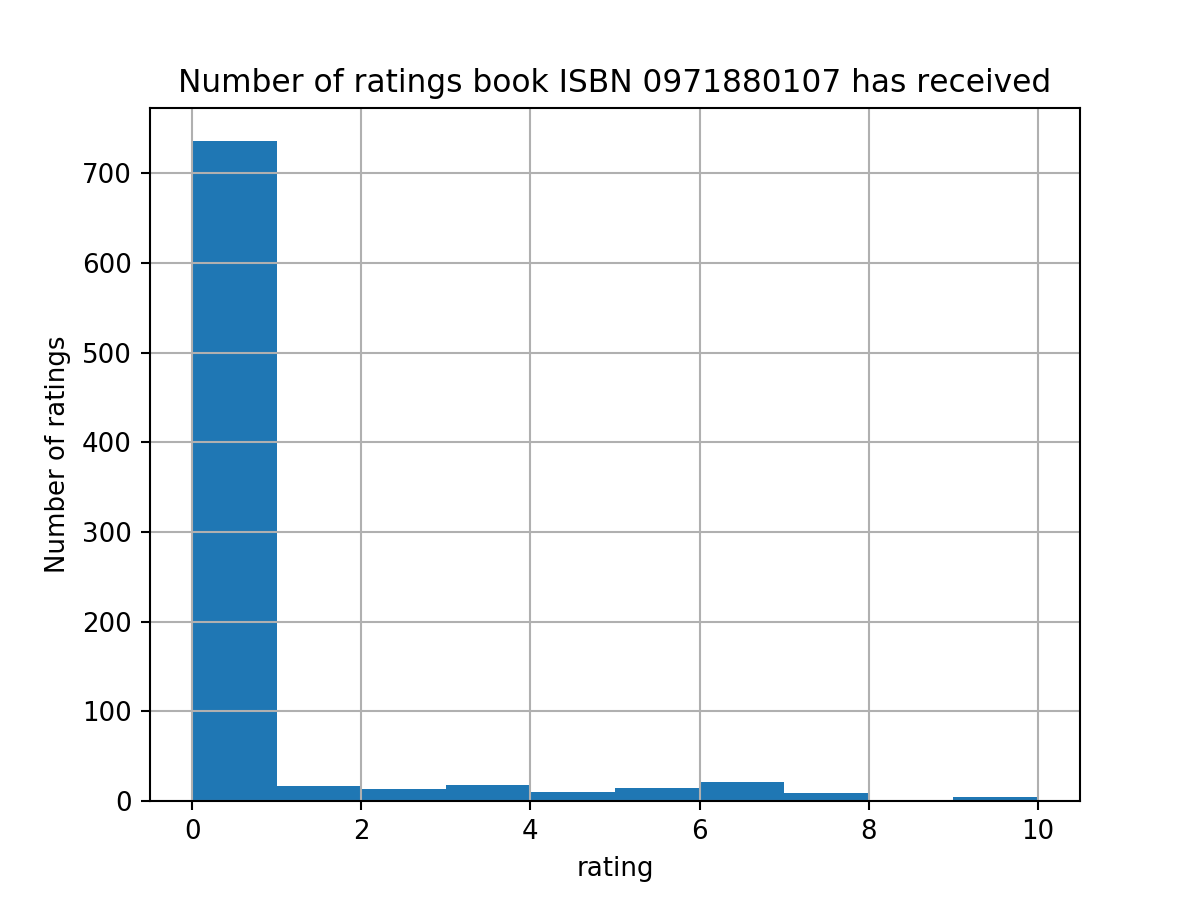

In [57]:
import matplotlib.pyplot as plt
%matplotlib notebook

df_new.loc[df_new['ISBN'] == '0971880107']['bookRating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings book ISBN 0971880107 has received')
plt.show();

It turns out, most of the ratings this book received was "0", in another word, most of the users in the data rated this book "0", only very few users rated "10". Same with the other predictions in "worst predictions" list. It seems that for each prediction, the users are some kind of outsiders.

You can deploy many more algorithms to build recommender systems with surprise. Here's another tutorial on using kNN: https://towardsdatascience.com/how-to-build-a-memory-based-recommendation-system-using-python-surprise-55f3257b2cf4